In [1]:
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logictensornetworks as ltn

# Data

Load the iris dataset: 50 samples from each of three species of iris flowers (setosa, virginica, versicolor), measured with four features.

In [2]:
df_train = pd.read_csv("iris_training.csv")
df_test = pd.read_csv("iris_test.csv")
print(df_train.head(5))

   sepal_length  sepal_width  petal_length  petal_width  species
0           6.4          2.8           5.6          2.2        2
1           5.0          2.3           3.3          1.0        1
2           4.9          2.5           4.5          1.7        2
3           4.9          3.1           1.5          0.1        0
4           5.7          3.8           1.7          0.3        0


In [3]:
labels_train = df_train.pop("species")
labels_test = df_test.pop("species")
batch_size = 64
ds_train = tf.data.Dataset.from_tensor_slices((df_train,labels_train)).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((df_test,labels_test)).batch(batch_size)

# LTN

Predicate with softmax `P(x,class)`

In [4]:
class MLP(tf.keras.Model):
    """Model that returns logits."""
    def __init__(self, n_classes, hidden_layer_sizes=(16,16,8)):
        super(MLP, self).__init__()
        self.denses = [tf.keras.layers.Dense(s, activation="elu") for s in hidden_layer_sizes]
        self.dense_class = tf.keras.layers.Dense(n_classes)
        self.dropout = tf.keras.layers.Dropout(0.2)
        
    def call(self, inputs, training=False):
        x = inputs
        for dense in self.denses:
            x = dense(x)
            x = self.dropout(x, training=training)
        return self.dense_class(x)

logits_model = MLP(4)
p = ltn.Predicate(ltn.utils.LogitsToPredicateModel(logits_model,single_label=True))

Constants to index/iterate on the classes

In [5]:
class_A = ltn.constant(0)
class_B = ltn.constant(1)
class_C = ltn.constant(2)

Operators and axioms

In [6]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")

In [7]:
formula_aggregator = ltn.fuzzy_ops.Aggreg_pMeanError(p=2)

@tf.function
def axioms(features, labels, training=False):
    x_A = ltn.variable("x_A",features[labels==0])
    x_B = ltn.variable("x_B",features[labels==1])
    x_C = ltn.variable("x_C",features[labels==2])
    axioms = [
        Forall(x_A,p([x_A,class_A],training=training)),
        Forall(x_B,p([x_B,class_B],training=training)),
        Forall(x_C,p([x_C,class_C],training=training))
    ]
    axioms = tf.stack(axioms)
    sat_level = formula_aggregator(axioms)
    return sat_level, axioms

Initialize all layers and the static graph

In [8]:
for features, labels in ds_test:
    print("Initial sat level %.5f"%axioms(features,labels)[0])
    break

Initial sat level 0.18089


# Training

Define the metrics. While training, we measure:
1. The level of satisfiability of the Knowledge Base of the training data.
1. The level of satisfiability of the Knowledge Base of the test data.
3. The training accuracy.
4. The test accuracy.
5. The satisfiability of some additional formula $\phi_1$, that we measure on the test data: $\forall x \big(\lnot \exists c1, c2: c1\neq c2 \big(P(x,c1) \land P(x,c2) \big) \big) $.

In [9]:
metrics_dict = {
    'train_sat_kb': tf.keras.metrics.Mean(name='train_sat_kb'),
    'test_sat_kb': tf.keras.metrics.Mean(name='test_sat_kb'),
    'train_accuracy': tf.keras.metrics.CategoricalAccuracy(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.CategoricalAccuracy(name="test_accuracy")
}

Define the training and test step

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
@tf.function
def train_step(features, labels):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(features, labels, training=True)[0]
        loss = 1.-sat
    gradients = tape.gradient(loss, p.trainable_variables)
    optimizer.apply_gradients(zip(gradients, p.trainable_variables))
    sat = axioms(features, labels)[0] # compute sat without dropout
    metrics_dict['train_sat_kb'](sat)
    # accuracy
    predictions = logits_model(features)
    metrics_dict['train_accuracy'](tf.one_hot(labels,3),predictions)
    
@tf.function
def test_step(features, labels):
    # sat
    sat = axioms(features, labels)[0]
    metrics_dict['test_sat_kb'](sat)
    # accuracy
    predictions = logits_model(features)
    metrics_dict['test_accuracy'](tf.one_hot(labels,3),predictions)

Train

In [11]:
import commons

EPOCHS = 500

commons.train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    csv_path="iris_results.csv",
    track_metrics=20
)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Epoch 0, train_sat_kb: 0.1825, test_sat_kb: 0.1825, train_accuracy: 0.3500, test_accuracy: 0.2667
Epoch 20, train_sat_kb: 0.3672, test_sat_kb: 0.3700, train_accuracy: 0.6333, test_accuracy: 0.7333
Epoch 40, train_sat_kb: 0.5091, test_sat_kb: 0.5074, train_accuracy: 0.6500, test_accuracy: 0.7333
Epoch 60, train_sat_kb: 0.5793, test_sat_kb: 0.5756, train_accuracy: 0.8250, test_accuracy: 0.6333
Epoch 80, train_sat_kb: 0.6117, test_sat_kb: 0.6080, train_accuracy: 0.8583, test_accuracy: 0.8000
Epoch 100, train_sat_kb: 0.6283, test_sat_kb: 0.6250, train_accuracy: 0.9667, test_accuracy: 1.0000
Epoch 120, train_sat_kb: 0.6492, test_sat_kb: 0.6467, train_accuracy: 0.9750, test_accuracy: 0.9667
Epoch 140, train_sat_kb: 0.6770, test_sat_kb: 0.6763, train_accuracy: 0.9833, test_accuracy: 0.9667
Epoch 160, train_sat_kb: 0.7116, test_sat_kb: 0.7147, train_accuracy: 0.9833, test_accuracy: 0.9667
Epoch 180, train_sat_kb: 0.7495, test_sat_kb: 0.7558, train_accuracy: 0.9917, test_accuracy: 0.9667
Epoch 

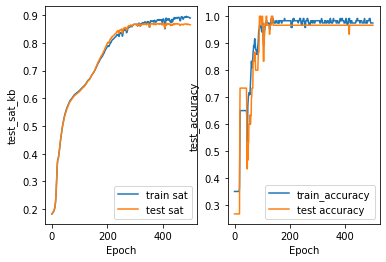

In [12]:
df_results = pd.read_csv("iris_results.csv")

import seaborn as sns
plt.subplot(121)
sns.lineplot(x="Epoch",y="train_sat_kb",data=df_results,label="train sat")
sns.lineplot(x="Epoch",y="test_sat_kb",data=df_results,label="test sat")
plt.subplot(122)
sns.lineplot(x="Epoch",y="train_accuracy",data=df_results,label="train_accuracy")
sns.lineplot(x="Epoch",y="test_accuracy",data=df_results,label="test accuracy")
plt.show()